# [Phystech@DataScience](https://thetahat.ru/courses/ph-ds-2025-spr)

# Семинар. Польза регуляризации.

Регуляризация — это важный и эффективный метод, применяемый в машинном обучении для решения ряда практических задач.

В этом ноутбуке мы увидим на простых примерах, как регуляризация помогает справляться с тремя распространёнными проблемами: переобучением, неустойчивостью модели и мультиколлинеарностью признаков.

In [34]:
import numpy as np
import scipy.stats as sps

from sklearn.linear_model import Ridge, Lasso, ElasticNet, LinearRegression
from sklearn.preprocessing import StandardScaler, PolynomialFeatures

import matplotlib.pyplot as plt
from matplotlib.figure import Figure
from matplotlib.axes import Axes
import ipywidgets as widgets
from typing import Tuple, List, Union

import warnings

warnings.filterwarnings("ignore")

import seaborn as sns

sns.set_theme("notebook", font_scale=1.2, palette="Set2")

# Сохраним цветовую палитру установленной темы Matplotlib
default_colors = plt.rcParams["axes.prop_cycle"].by_key()["color"]

random_state = 42

## 1. Переобучение и неустойчивость модели

Для начала рассмотрим простой пример, демонстрирующий явление переобучения.

### 1.1 Идеальные данные

Определим многочлен третьей степени, который хотим приблизить по 10 точкам на отрезке $[-1, 1]$:

$$
    f(x) = 3x^3 - 2x^2 + x
$$

In [35]:
def f(x: float):
    """Целевая функция."""
    return 3 * (x**3) - 2 * (x**2) + x

Создадим сетку из 300 точек, на которых далее будем сравнивать получаемые приближения с самой функцией:

In [36]:
x_grid = np.linspace(-1, 1, 300).reshape(-1, 1)
y_grid_values = f(x_grid)

Изобразим график целевой функции:

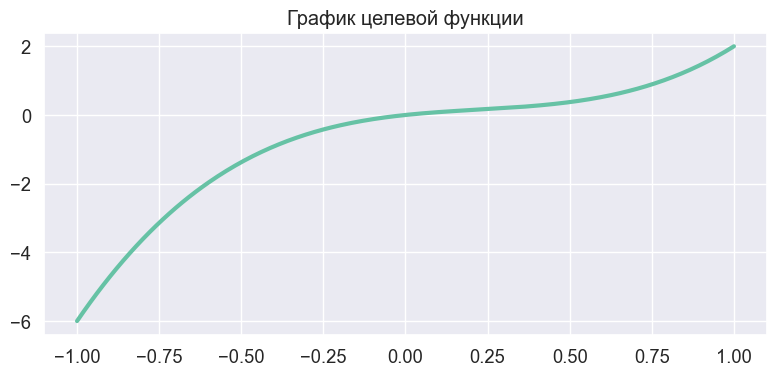

In [37]:
plt.figure(figsize=(8, 4), tight_layout=True)
plt.plot(x_grid, y_grid_values, linewidth=3)
plt.title("График целевой функции");

Будем аппроксимировать наш многочлен по 10 точкам из отрезка $[-1, 1]$ &mdash; это *обучающая выборка*.

In [38]:
sample_size = 10

# Фиксируем обучающую выборку и отклики
x_train = sps.uniform.rvs(
    -1, 2, (sample_size, 1), random_state=random_state
)  # 10 точек на отрезке [-1, 1]
y_train = f(x_train)

Определим функцию для визуализации экспериментов:

In [39]:
def plot_poly(
    x_train: np.ndarray,
    y_train: np.ndarray,
    x_grid: np.ndarray,
    y_grid_values: np.ndarray,
    y_approx: np.ndarray,
    graph_title: str,
) -> Figure:
    """Функция для визуализации приближения многочленом.

    Args:
        x_train (np.ndarray): Узлы аппроксимации (обучающая выборка, регрессоры)
        y_train (np.ndarray):Отклики на обучающей выборке
        x_grid (np.ndarray): Сетка для визуализации (тестовая выборка)
        y_grid_values (np.ndarray): Значения целевой функции на тестовой выборке
        y_approx (np.ndarray): Полученное приближение для y_grid_values
        graph_title (str): Заголовок для графика

    Returns:
        Figure: Объект Figure с построенным графиком
    """

    figure = plt.figure(figsize=(7, 3.5), tight_layout=True)

    plt.scatter(x_train, y_train, s=100, label="Обучающая выборка")
    plt.plot(x_grid, y_grid_values, label="Целевая функция", linewidth=5)
    plt.plot(x_grid, y_approx, label="Аппроксимация", linewidth=3)

    plt.title(graph_title)
    plt.legend()
    plt.ylim((-8, 4))

    return figure

>#### Пара технических моментов
>
>Для того, чтобы строить приближения моделями `sklearn` необходимо преобразовать одномерный массив $x$ в матрицу, в столбцах которой будут степени $x$. Для этого можно использовать готовый трансформер [`sklearn.PolynomialFeatures`](https://colab.research.google.com/drive/1vNNYa6g_rzqD1G4EE0bG_gOyDst2a-0Z?authuser=1#scrollTo=03timReQf5rK&line=1&uniqifier=1).
>
> **Важные аргументы конструктора:**
*   `degree` &mdash; максимальная степень
*   `include_bias` &mdash; добавлять ли сдвиг (т. е. нулевую степень). По-умолчанию, `True`.
>
>**Основные методы класса:**
*   `fit(X)` &mdash; считает количество признаков в `X`
*   `transform(X)` &mdash; присоединяет к массиву `X` массивы `X`$^2$, `X`$^3$ и т.д.
>   *Примечание*. в общем случае `X` может быть матрицей с $d > 1$ признаками.

In [40]:
# Создаём трансформер с заданной степенью многочлена
poly_features = PolynomialFeatures(degree=2).set_output(transform="pandas")

# Делаем преобразование массивов
X_train_poly = poly_features.fit_transform(x_train)
X_true_poly = poly_features.transform(x_grid)
X_train_poly.head(3)

1        x0      x0^2
0  1.0 -0.250920  0.062961
1  1.0  0.901429  0.812574
2  1.0  0.463988  0.215285

>Заметим, что у нас вырисовывался некий *пайплайн*, т.е. шаблонный алгоритм:
1.  Сначала мы преобразуем признак
2.  Затем обучаем модель
>
>Эти шаги неразделимы, поэтому удобно поместить их в один "контейнер" и работать с ним как с обычной моделью. Для этого в `sklearn` придумали класс [`Pipeline`](https://scikit-learn.org/stable/modules/generated/sklearn.pipeline.Pipeline.html):

In [41]:
from sklearn.pipeline import Pipeline

model = Pipeline(
    [
        ("step_1", PolynomialFeatures(degree=2)),   # Сначала преобразование над x (одно или несколько)
  
        ("step_2", LinearRegression(fit_intercept=False))   # Потом fit или predict модели
    ]
)

>Теперь можно работать с `model` также, как с любой моделью `sklearn`, при этом преобразование над признаками будет происходить автоматически.

#### Возвращаемся к данным
Попробуем приблизить выборку квадратичной функцией:

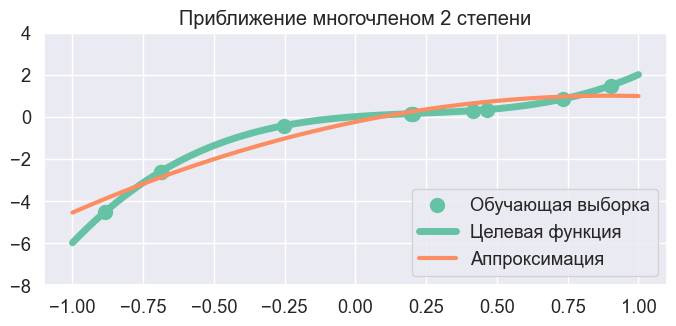

In [42]:
# Обучение
model.fit(x_train, y_train)  # Теперь fit автоматически добавляет
# полиномиальные фичи и обучает лин. рег.

# Значения приближенной функции на тестовой сетке x_test
y_approx = model.predict(x_grid)

# визуализация
plot_poly(
    x_train,
    y_train,
    x_grid,
    y_grid_values,
    y_approx,
    f"Приближение многочленом {model.get_params()['step_1__degree']} степени",
);

Неудивительно, что многочлен третьей степени плохо приближается многочленом второй.

Если взять правильную степень, то получим полное совпадение:

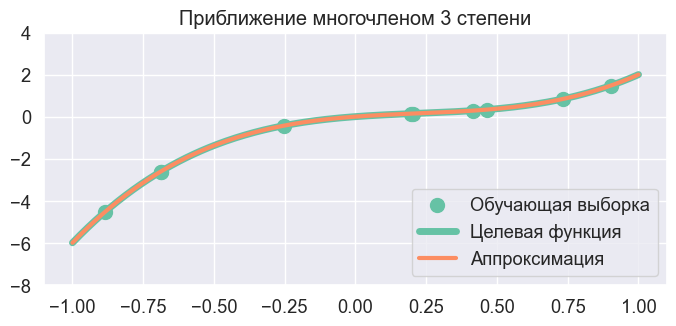

In [43]:
# Меняем степень
model["step_1"].set_params(degree=3)  # - так можно изменить параметр
#  `degree` на шаге `step_1`

# Обучаем модель и считаем приближение на тестовой сетке x_test
model.fit(x_train, y_train)
y_approx = model.predict(x_grid)

# визуализация
plot_poly(
    x_train,
    y_train,
    x_grid,
    y_grid_values,
    y_approx,
    f"Приближение многочленом {model['step_1'].get_params()['degree']} степени",
);

Получили идеальное совпадение.

### 1.2 Суровая реальность

На практике мы редко имеем идеальные данные, которые полностью отражают искомую зависимость.

Попробуем добавить в нашу функцию случайный шум:

In [44]:
def f_real(x: float, random_state: int = 0):
    """Целевая функция + шум."""
    return (
        3 * (x**3)
        - 2 * (x**2)
        + x
        + sps.norm.rvs(0, 1, x.shape, random_state=random_state)
    )

И определим случайные отклики на обучающей выборке:

In [45]:
y_train = f_real(x_train, random_state)

Далеко не всегда заранее известна степень полинома. Мы можем вообще не знать, полином это или нечто другое. Посмотрим, что будет, если пытаться построить приближение многочленом, например, 7-й степени.




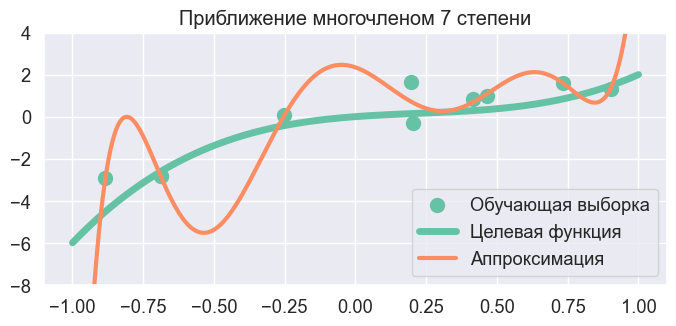

In [46]:
# Меняем степень
model["step_1"].set_params(degree=7)

# Обучаем модель и считаем приближение на тестовой сетке x_test
model.fit(x_train, y_train)
y_approx = model.predict(x_grid)

plot_poly(
    x_train,
    y_train,
    x_grid,
    y_grid_values,
    y_approx,
    f"Приближение многочленом {model['step_1'].get_params()['degree']} степени",
);

Именно так и проявляется переобучение: мы создали модель, которая слишком хорошо адаптировалась к тренировочным данным, фактически запомнив их. В результате, модель **выучила не общую закономерность, а частные особенности тренировочной выборки**, включая шум. Она не способна хорошо обобщаться на новые, ранее не виденные данные.

### 1.3 Масштаб катастрофы

Для наглядности проведём эксперимент: сгенерируем 100 аналогичных выборок данных и для каждой из них построим **свою** модель.

Фиксируем выборки:

In [47]:
def generate_samples(
    samples_count: int, x_train: np.ndarray
) -> List[np.ndarray]:
    """Генерирует samples_count откликов для выборки x_train.

    Args:
        samples_count (int): Количество сгенерированных выборок.
        x_train (np.ndarray): Исходные данные.

    Returns:
        List[np.ndarray]: Список массивов сгенерированных откликов.
    """

    return [
        f_real(x_train, random_state) for random_state in range(samples_count)
    ]


y_train_all = generate_samples(100, x_train)

Напишем функцию, которая много раз обучит линейную модель на заданном наборе выборок и визуализирует полученные приближения:

In [48]:
def plot_many_poly(
    models: Union[Pipeline, List[Pipeline]],
    y_train_all: List[np.ndarray],
    x_train: np.ndarray,
    x_grid: np.ndarray,
    y_grid_values: np.ndarray,
    graph_title: str = "",
) -> Tuple[Figure, Union[Axes, List[Axes]]]:
    """Обучает много одинаковых моделей на разных реализациях отклика и
    отображает на графике полученные приближения.

    Args:
        models (Union[RegressorMixin, List[RegressorMixin]]): Одна модель или список моделей sklearn.
        y_train_all (List[np.ndarray]): Список массивов откликов для обучения.
        x_train (np.ndarray): Обучающая выборка.
        x_grid (np.ndarray): Сетка для визуализации (тестовая выборка).
        y_grid_values (np.ndarray): Значения целевой функции на тестовой сетке.
        graph_title (str, optional): Заголовок для графика. По умолчанию пустая строка.

    Returns:
        Tuple[Figure, Union[Axes, List[Axes]]]: Фигура и оси с построенными графиками.
    """
    # Если передана одна модель, преобразуем её в список
    if not isinstance(models, list):
        models = [models]

    n_models = len(models)

    # Создаем фигуру и оси
    fig, axs = plt.subplots(
        1, n_models, figsize=(7, 3.5), tight_layout=True, sharey=True
    )

    # Если передана только одна модель, превращаем axs в список из одного элемента
    if n_models == 1:
        axs = [axs]

    for i, model in enumerate(models):
        ax = axs[i]
        for y_train in y_train_all:
            # Обучаем модель и считаем приближение на тестовой сетке x_test
            model.fit(x_train, y_train)
            y_approx = model.predict(x_grid)

            # Отображаем на общем графике кривую и точки выборки
            ax.plot(x_grid, y_approx, linewidth=0.5, color="#fc8d62")
            ax.scatter(x_train, y_train, s=200, alpha=0.5, color="#66c2a5")

        ax.plot(x_grid, y_grid_values, label="Целевая функция", linewidth=5)
        ax.legend()
        ax.set_ylim((-8, 4))
        ax.set_title(graph_title)

    return fig, axs

Некоторые аргументы функции мы фиксировали, поэтому для краткости удобно передавать их единым словарём:

In [49]:
fixed_kwargs = {
    "x_train": x_train,  # тренировочная выборка
    "y_train_all": y_train_all,  # отклики на тренировочной выборке, много штук
    "x_grid": x_grid,  # тестова сетка
    "y_grid_values": y_grid_values,  # значения функции на сетке
}

И сам эксперимент:

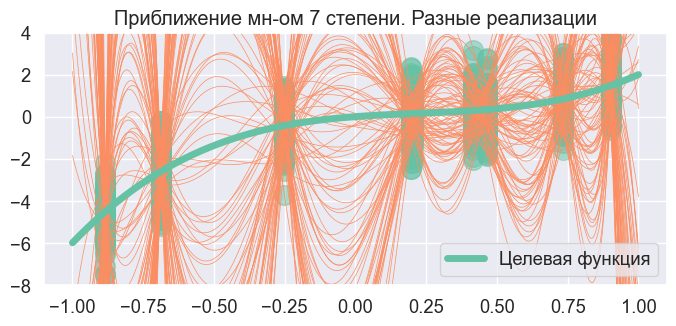

In [50]:
plot_many_poly(
    models=model,
    graph_title=f"Приближение мн-ом {model['step_1'].get_params()['degree']} степени. Разные реализации",
    **fixed_kwargs,
);

Важно отметить: **единственное, что менялось** при каждом повторении – это **значения зависимой переменной $y$**, из-за добавления к ним случайного (гауссова) шума. Это значит, что неустойчивость приближения напрямую связана с тем, как модель подстраивается под этот шум.

В результате, мы получили не только неточные приближения, но и крайне нестабильные. **Модель очень чувствительна к изменениям в тренировочных данных и ведет себя непредсказуемо.**

А что, если бы мы с самого начала выбрали правильную степень полинома? Возможно, тогда мы получили бы более качественную аппроксимацию? Давайте проверим это:

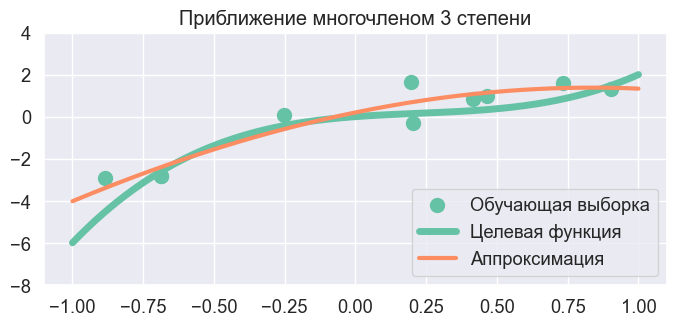

In [51]:
# Меняем степень
model.set_params(step_1__degree=3)

# Обучаем модель и считаем приближение на тестовой сетке x_test
model.fit(x_train, y_train)
y_approx = model.predict(x_grid)

plot_poly(
    x_train,
    y_train,
    x_grid,
    y_grid_values,
    y_approx,
    f"Приближение многочленом {model['step_1'].get_params()['degree']} степени",
);

Хороший ли это результат? &mdash; Как повезёт. Всё также зависит от реализации $y$. Проведём аналогичный эксперимент:

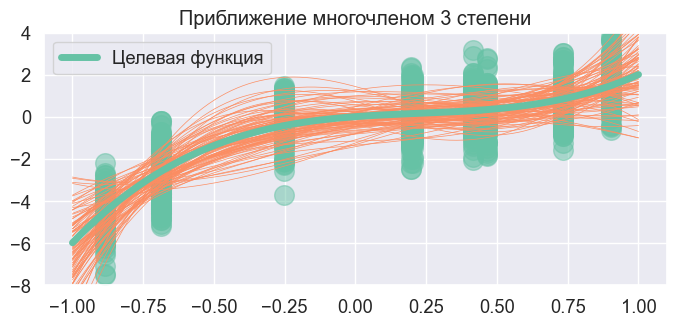

In [52]:
plot_many_poly(
    models=model,
    graph_title=f"Приближение многочленом {model['step_1'].get_params()['degree']} степени",
    **fixed_kwargs,
);

Выглядит значительно лучше, чем в случае 7-й степени. Тем не менее, даже здесь есть ряд заметных недостатков:

*   На правом краю интервала некоторые кривые начинают убывать, в то время как исходная функция имеет тенденцию к возрастанию.

*   Можно наблюдать значительную разницу в форме кривых: некоторые имеют неестественно большую выпуклость, а другие, напротив, почти линейны

### 1.3 Регуляризация повышает устойчивость

В задаче линейной регрессии наиболее часто используют модели
 [Ridge](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Ridge.html), [Lasso](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Lasso.html) и [ElasticNet](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.ElasticNet.html).

> * **Ridge** &mdash; это модель линейной регрессии с $L_2$-регуляризацией, которая минимизирует функционал\
$$
    \lVert Y - X \theta\rVert^2_2 + \alpha  \lVert\theta\rVert^2_2 → \min_\theta
$$
Здесь $Y \in \mathbb{R}^{n}$ &mdash; истинные значения целевой переменной, $X \in \mathbb{R}^{n\times d}$ &mdash; матрица "объект-признак", ${\theta} \in \mathbb{R}^{d}$ &mdash; коэффициенты модели. Параметр регуляризации $\alpha \geq 0$ управляет силой штрафа. Является **гиперпараметром**, т.е. задаётся пользователем.
* **Lasso** &mdash; модель линейной регрессии с $L_1$-регуляризацией. Минимизирует функционал\
$$
    \lVert Y - X \theta\rVert^2_2 + \alpha  \lVert\theta\rVert_1 → \min_\theta
$$
* **ElasticNet** &mdash; компромисс между двумя предыдущими. Минимизирует функционал\
$$
    \lVert Y - X\theta\rVert^2_2 + \alpha_1  \lVert\theta\rVert_1 + \alpha_2  \lVert\theta\rVert^2_2 → \min_\theta
$$

Также важно помнить, что перед тем как применять регуляризацию, данные нужно стандартизировать.

&#x2753; **Зачем?** &#x2753;

<details>
  <summary> Кликни для показа ответа </summary>
  
> Поскольку гиперпараметр $\alpha$ умножается на норму коэффициентов модели, необходимо их *обезразмерить*. Это достигается путём **стандартизации** всех признаков. Кроме того, стандартизация приводит признаки к единому масштабу, а значит модель будет отдавать *равное* предпочтение признакам как с б**о**льшими, так и с меньшими значениями. Это особенно важно в нашем случае, когда $x$ явно меняет масштаб при возведении в степень.

</details><br/>

>Есть много способов стандартизации, из которых наиболее распространены два следующих.
1. <a target="_blank" href="https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html"><it>StandardScaler</it></a>. Пусть $x_{ij}$ &mdash; значение признака $j$ для объекта $i$. Обозначим $m_j$ &mdash; выборочное среднее значение признака $j$ (функция `np.mean`), а $s^2_j$ &mdash; выборочную дисперсию признака $j$ (функция `np.var`). Тогда стандартизацией является преобразование
$$\widetilde{x}_{ij} = \frac{x_{ij} - m_j}{s_j}.$$
2. <a target="_blank" href="https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.MinMaxScaler.html"><it>MinMaxScaler</it></a>. Пусть $x_{ij}$ &mdash; значение признака $j$ для объекта $i$. Обозначим $m_j$ и $M_j$ &mdash; минимальное и максимальное значения признака $j$ соответственно. Тогда стандартизацией является преобразование
$$\widetilde{x}_{ij} = \frac{x_{ij} - m_j}{M_j - m_j}.$$

Проведём аналогичный эксперимент для модели с регуляризацией. Сравним с работой МНК. Для этого понадобится создать ещё один *пайплайн:*

In [53]:
model_reg = Pipeline(
    [                                           
        ("step_1", PolynomialFeatures(degree=3, include_bias=False)),   # Учёт сдвига перенесём в саму модель

        ("step_2", StandardScaler()),  # Добавили стандартизацию

        ("step_3", Ridge(fit_intercept=True, alpha=1)),  # Заменили LinearRegression Ridge
    ]
)

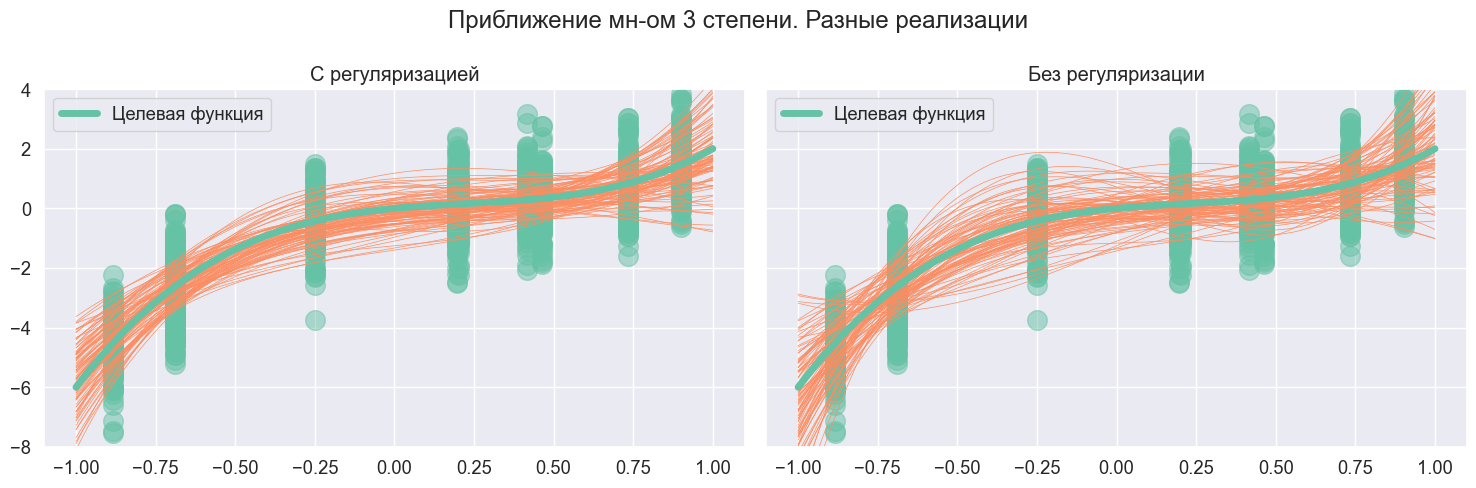

In [54]:
fig, (ax1, ax2) = plot_many_poly(models=[model_reg, model], **fixed_kwargs)
fig.set_size_inches(15, 5)
fig.suptitle(
    f"Приближение мн-ом {model['step_1'].get_params()['degree']} степени. Разные реализации"
)
ax1.set_title("С регуляризацией")
ax2.set_title("Без регуляризации");

Невооружённым глазом видно улучшение некоторых недостатков: кривые аппроксимации идут практически единым потоком, близко друг к другу, что свидетельствует о повышении устойчивости модели.

### 1.4 Что там с переобучением?

Вернёмся к степени 7. Применение регуляризации в этом случае также сильно спасает ситуацию:

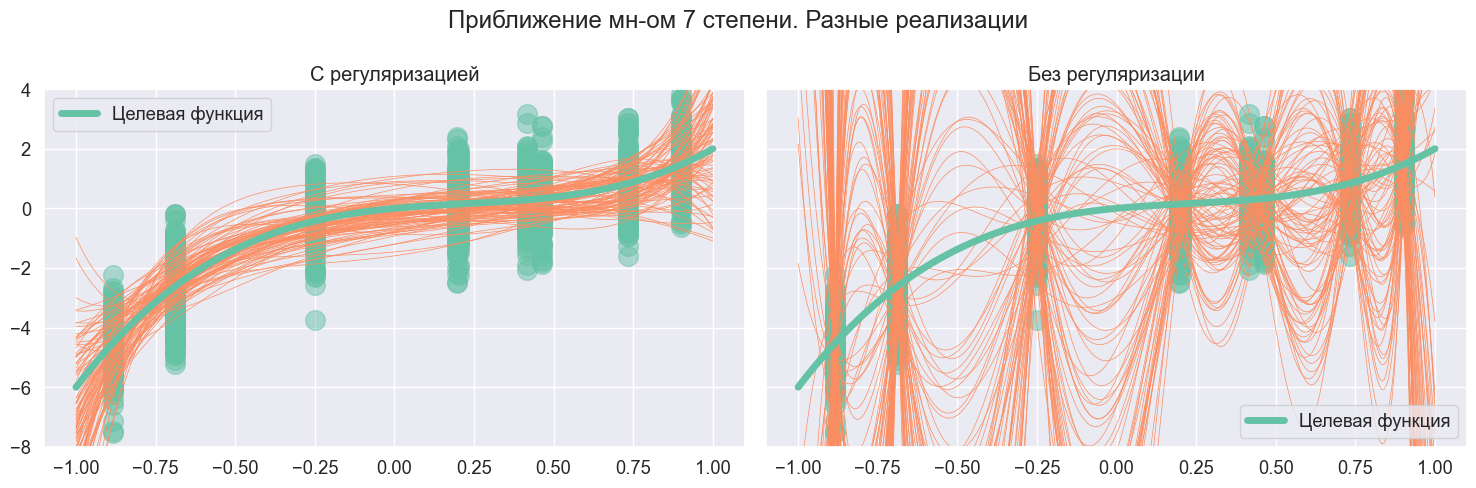

In [55]:
# Меняем степень
model["step_1"].set_params(degree=7)
model_reg["step_1"].set_params(degree=7)

fig, (ax1, ax2) = plot_many_poly(models=[model_reg, model], **fixed_kwargs)
fig.set_size_inches(15, 5)
fig.suptitle(
    f"Приближение мн-ом {model['step_1'].get_params()['degree']} степени. Разные реализации"
)
ax1.set_title("С регуляризацией")
ax2.set_title("Без регуляризации");

Не так хорошо, как с 3-й степенью, однако результат всё равно впечатляет: исчезли ненужные осцилляции, практически все кривые задают единый тренд.

**Таким образом,** регуляризация:

*   повышает устойчивость модели: теперь при разных реализациях выборки модели ведут себя намного более согласованно;

*   избавляет от необходимости тщательного подбора вида искомой функции. Приближение многочленом как 3-й, так и 7-степени, даёт приемлемые результаты, за исключением, может быть, приграничных областей.





### 1.5 Параметр регуляризации



Теперь посмотрим, как параметр регуляризации влияет на коэффициенты модели и предсказание. Для начала, напишем функцию, обучающую модель с параметром регуляризации `alpha` и отображающую коэффициенты модели и получившуюся аппроксимацию.

In [56]:
def poly_regular_visualize(
    degree: int,
    alpha: float,
    model: str,
    x_train: np.ndarray,
    y_train: np.ndarray,
    x_grid: np.ndarray,
    y_grid_values: np.ndarray,
):
    """Визуализирует предсказание и коэффициенты модели с заданным параметром
    регуляризации.

    Args:
        degree (int): Степень многочлена, которым делается приближение.
        alpha (float): Коэффициент регуляризации.
        model (str): Тип модели ('Ridge', 'Lasso' или 'Elastic').
        x_train (np.ndarray): Узлы аппроксимации (обучающая выборка, регрессоры).
        y_train (np.ndarray): Отклики на обучающей выборке.
        x_grid (np.ndarray): Сетка для визуализации (тестовая выборка).
        y_grid_values (np.ndarray): Значения целевой функции на тестовой выборке.
    """

    # Инициализируем нужную модель
    if model == "Ridge":
        model_instance = Ridge(alpha=alpha, max_iter=1000, fit_intercept=True)
    elif model == "Lasso":
        model_instance = Lasso(alpha=alpha, max_iter=1000, fit_intercept=True)
    elif model == "Elastic":
        model_instance = ElasticNet(
            alpha=alpha, max_iter=1000, fit_intercept=True
        )
    else:
        return None

    # Добавим к модели преобразования признаков
    pipeline_model = Pipeline(
        [
            ("step_1", PolynomialFeatures(degree=degree, include_bias=False)),
            ("step_2", StandardScaler()),
            ("step_3", model_instance),
        ]
    ).fit(
        x_train, y_train
    )  # ...и сразу обучим

    # Получаем предсказания
    y_approx = pipeline_model.predict(x_grid)

    # Визуализация
    figure = plt.figure(figsize=(10, 6), tight_layout=True)

    # График предсказания
    plt.subplot(2, 1, 1)
    plt.scatter(x_train, y_train, s=100, label="Обучающая выборка")
    plt.plot(x_grid, y_grid_values, label="Целевая функция", linewidth=5)
    plt.plot(x_grid, y_approx, label="Аппроксимация", linewidth=3)
    plt.ylabel("y")
    plt.legend()

    # График коэффициентов
    plt.subplot(2, 1, 2)
    plt.bar(
        ["$x^0$"] + [f"$x^{p[0]}$" for p in pipeline_model["step_1"].powers_],
        model_instance.intercept_.flatten().tolist()
        + model_instance.coef_.flatten().tolist(),
    )
    plt.ylabel("Коэф.")

Переопределим отклики на обучающей выборке и создадим виджет для варьирования параметров модели:

In [57]:
y_train = f_real(x_train)

# Создаём виджет с возможностью менять `alpha` и вид регуляризации
ip = widgets.interact(
    poly_regular_visualize,
    degree=widgets.IntSlider(min=1, max=10, value=7),
    model="Ridge",
    alpha=widgets.FloatSlider(min=0.0001, max=4, step=0.01, value=0),
    x_train=widgets.fixed(x_train),
    y_train=widgets.fixed(y_train),
    x_grid=widgets.fixed(x_grid),
    y_grid_values=widgets.fixed(y_grid_values),
);

interactive(children=(IntSlider(value=7, description='degree', max=10, min=1), FloatSlider(value=0.0001, descr…

**Выводы**

*   При росте штрафа величины коэффициентов уменьшаются
*   Lasso-регрессия зануляет часть коэффициентов
*   Чем выше степень полинома, тем сильнее нужен штраф

А теперь посмотрим на общую картину: создадим сетку "альф", для каждого значения обучим модель и запомним коэффициенты. Ниже реализована функция для произвольной линейной модели.

In [25]:
def train_alpha_grid(
    model: Pipeline,
    x_train: np.ndarray,
    y_train: np.ndarray,
    alpha_grid: np.ndarray,
) -> np.ndarray:
    """Обучает модель для разных значений параметра регуляризации и сохраняет
    коэффициенты.

    Args:
        model (Pipeline): Конвейер (Pipeline) со степенями полинома, стандартизацией и моделью регуляризации.
        x_train (np.ndarray): Обучающая выборка.
        y_train (np.ndarray): Отклик на обучающей выборке.
        alpha_grid (np.ndarray): Массив значений параметра регуляризации (alpha).

    Returns:
        np.ndarray: Массив коэффициентов моделей с разной силой штрафа.
    """

    coefs = []

    for a in alpha_grid:
        model["step_3"].set_params(
            alpha=a
        )  # Устанавливаем новое значение alpha
        model.fit(x_train, y_train)  # Обучаем модель

        # Сохраняем коэффициенты (intercept + coef_)
        coefs.append(
            model["step_3"].intercept_.flatten().tolist()
            + model["step_3"].coef_.flatten().tolist()
        )

    return np.array(coefs)

Отдельно для каждой модели нарисуем треки всех коэффициентов в зависимости от альфа:

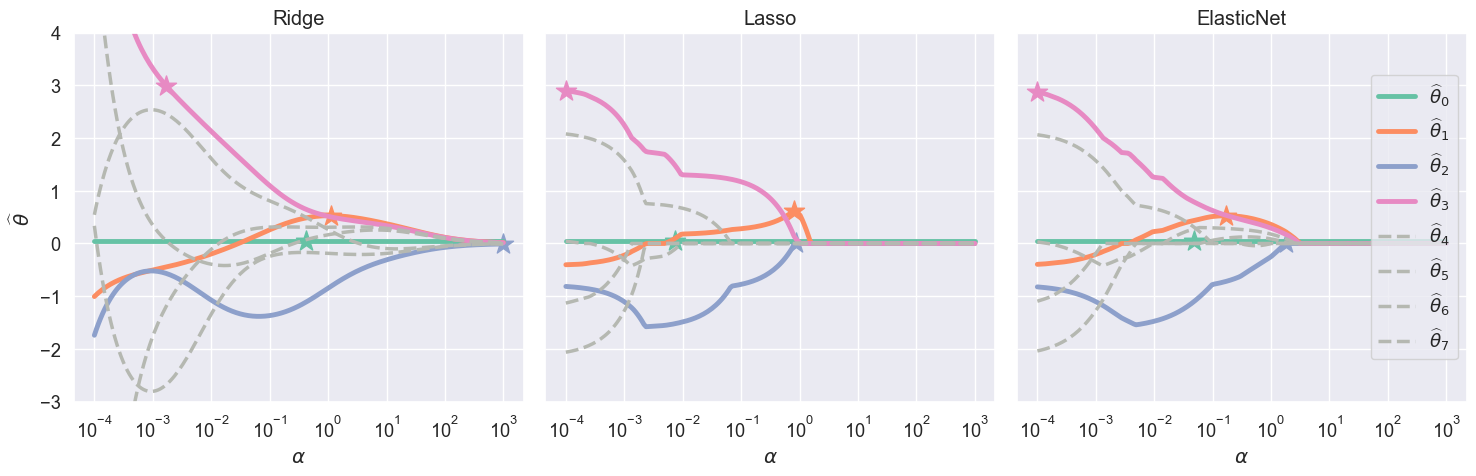

In [26]:
# Сетка значений alpha
alpha_grid = np.logspace(-4, 3, 200)

# Вновь рассматриваем три модели
models_dict = {
    "Ridge": Ridge(fit_intercept=True),
    "Lasso": Lasso(fit_intercept=True),
    "ElasticNet": ElasticNet(fit_intercept=True),
}


fig, ax_list = plt.subplots(
    1, 3, figsize=(15, 5), tight_layout=True, sharey=True
)

# Сопоставим цвета для коэффициентов:
# первые 4 "правильных" — стандартно
# остальные — серым
colors = default_colors[:4] + [(181 / 255, 184 / 255, 177 / 255)] * 4

# Перебираем модели и строим графики коэффициентов
for ax, (model_name, model) in zip(ax_list, models_dict.items()):

    model = Pipeline(
        [
            ("step_1", PolynomialFeatures(degree=7, include_bias=False)),
            ("step_2", StandardScaler()),
            ("step_3", model),
        ]
    )
    # Обучаем модель на различных значениях alpha и получаем коэффициенты
    coefs = train_alpha_grid(model, x_train, y_train, alpha_grid)

    # Истинные коэффициенты для сравнения
    true_coefs = [0, 1, 2, 3]

    # Визуализация изменения коэффициентов при разной alpha
    for i, coef_track in enumerate(coefs.T):
        if i < 4:
            arg_best = np.argmin(np.abs(coef_track - true_coefs[i]))
            ax.scatter(
                alpha_grid[arg_best],
                coef_track[arg_best],
                marker="*",
                c=colors[i],
                s=230,
            )
            lw, ls = 3.5, "-"
        else:
            lw, ls = 2.5, "--"
        ax.plot(
            alpha_grid,
            coef_track,
            label=f"$\\widehat{{\\theta}}_{i}$",
            color=colors[i],
            lw=lw,
            ls=ls,
        )

    # Настройка осей и заголовков
    ax.set_title(model_name)
    ax.set_xlabel("$\\alpha$")
    ax.set_xscale("log")
    ax.set_ylim((-3, 4))

# Общие настройки
ax_list[0].set_ylabel("$\\widehat{\\theta}$")
ax_list[-1].legend(loc="right");

$$
    f(x) = 3x^3 - 2x^2 + x
$$

Звёздочками ✨ отмечены точки, в которых коэффициенты достигают своих истинных значений. Как мы видим, регуляризация не позволяет "исправить" все коэффициенты одновременно.

Также отметим, что

*   Для Lasso-регрессии характерны резкие скачки в местах, где зануляется хотя бы один из коэффициентов

*   Elastic-регрессия являет собой нечто среднее: есть зануляющиеся коэффициенты, но спад более плавный, чем у Lasso


## 2. Проблема мультиколлинеарности

Переобучение и нестабильность модели часто являются следствием явления под названием *мультиколлинеарность*.

Это ситуация, когда между признаками существует линейная или почти линейная зависимость. Другими словами, признаки могут быть сильно скоррелированы, что приводит к нестабильным и часто завышенным коэффициентам модели.

В разобранном выше примере с аппроксимацией полиномом 7-й степени мы и наблюдали следствие таких корреляций. Скажем, зависимость между признаками $x^6$ и $x^7$ не так уж далека от линейной. А при $n \rightarrow \infty$ признаки $x^{n-k}$ и $x^n$ и вовсе становятся идентичны для любого фиксированного $k$. Как следствие &mdash; большой разброс в коэффициентах многочлена, выражавшийся в грандиозных отличиях аппроксимирующих кривых, казалось бы, одинаковых моделей.

Мультиколлинеарность тесно связана с понятием **числа обусловленности**. Оно определяет  устойчивость многих численных методов, и линейной регрессии в частности. Для квадратной матрицы $X^TX$ его можно определить как отношение её наибольшего и наименьшего собственных чисел:
$$
    κ(X^TX) = \frac{\lambda_1}{\lambda_n}
$$
Для прямоугольной матрицы $X$ верно простое соотношение:
$$
    \kappa(X) = \sqrt{κ(X^TX)}
$$
Чем меньше число обусловленности, тем более устойчиво решение задачи, т.е. обученная модель, в нашем случае.
> ℹ️ См. также про [сингулярное разложение.](http://www.machinelearning.ru/wiki/index.php?title=Сингулярное_разложение)

### 2.1 Разброс ответов модели

Отойдём от примера с многочленом и рассмотрим простую линейную комбинацию признаков:

$$
    y(x) = 1 + 2x_0 + 5x_1 + 3.5x_2 + x_3 - x_4 + ɛ, \hspace{1cm} \varepsilon \sim \mathcal{N}(0, 1)
$$

Если некоторые из признаков оказываются линейно зависимыми, то задача регрессии, то есть поиск приближенной вещественнной функции, становится некорректной из-за неоднозначности решения. Действительно, если $x_3 \equiv x_4$, то существует бесконечное множество наборов коэффициентов, например, $(\widehat{\theta}_0, \widehat{\theta}_1, \widehat{\theta}_2, \widehat{\theta}_3, \widehat{\theta}_4) = (…, 1, 1)$, или $(…, 100, 100)$, или $(…, -\pi, -\pi)$, и так далее. Все эти наборы дадут одинаковые предсказания.

На практике, конечно же, линейная зависимость не является строгой, и решение всегда одно. Тем не менее, даже небольшие изменения в данных могут привести к значительным колебаниям в значениях коэффициентов модели и, как следствие, к нестабильным прогнозам.

 🔎 *Исследуем конкретный пример*\
Пусть признаки $x_1$, $x_2$ и $x_3$ &mdash; приближённо линейно-зависимы:
$$
    x_3 = x_2 - 2.5x_1 + 2.5x_4 + \delta, \hspace{1cm} \delta \sim \mathcal{N}(0, σ_{noise}^2)
$$
Здесь $\delta$ — случайный шум, определяющий "силу" линейной зависимости между признаками.
Реализуем непосредственно линейную функцию, а также функцию, которая будет добавлять мультиколлинеарность в наши данные.

>&#x2755;*Замечание*&#x2755; Ранее мы добавляли шум только в целевую функцию, а теперь ещё и в признаки.

In [27]:
def y(x: np.ndarray, with_noise: bool = True) -> np.ndarray:
    """Целевая функция + шум."""

    noise = np.random.normal(0, 1, x.shape[0]) * with_noise
    return (
        1
        + 2 * x[:, 0]
        + 5 * x[:, 1]
        + 3.5 * x[:, 2]
        + x[:, 3]
        - x[:, 4]
        + noise
    )


def add_multicollinearity(
    x: np.ndarray, noise_std: float = 0.0001
) -> np.ndarray:
    """Вносит погрешность в признак x4 для создания мультиколлинеарности."""

    x[:, 3] = (
        x[:, 2]
        - 2.5 * x[:, 1]
        + 2.5 * x[:, 4]
        + np.random.normal(0, noise_std, x.shape[0])
    )
    return x

Саму функцию визуализировать не будем, поскольку размерность экрана на 3 меньше числа переменных.

Линейная модель, аппроксимирующая данные:
$$
    \widehat{y} = X\widehat{\theta}
$$

Напишем функцию, которая будет обучать заданную модель много раз на таких синтетических данных и возвращать предсказания на одной заданной точке. При этом мы фиксируем признаки изначально, а $x_3$ и $y$ будут варьироваться из-за случайного шума.

> &#x2755;*Замечание*&#x2755; Попутно будем считать число обусловленности. В случае Ridge-регрессии с $\alpha \geq 0$ нас будет интересовать обусловленность матрицы $X^TX + \alpha I_5$

In [28]:
def fit_predict_ntimes(
    X_train: np.ndarray,
    X_test_point: np.ndarray,
    alpha: float = 0.0,
    n_repeats: int = 1000,
    feature_noise_std: float = 0.01,
) -> Tuple[np.ndarray, float]:
    """Обучает n_repeats раз Ridge-регрессию со штрафом alpha и возвращает
    предсказания на X_test_point вместе со средним числом обусловленности.

    Args:
        X_train (np.ndarray): Обучающая выборка (размерность [n_samples, n_features]).
        X_test_point (np.ndarray): Тестовая точка (размерность [1, n_features]).
        alpha (float): Коэффициент регуляризации.
        n_repeats (int): Число повторений.
        feature_noise_std (float): Стандартное отклонение шума в признаках (влияет на обусловленность).

    Returns:
        Tuple[np.ndarray, float]:
            - np.ndarray: Массив предсказаний на объекте X_test_point (размер n_repeats).
            - float: Среднее число обусловленности.
    """

    # Сюда будем записывать числа обусловленности
    cond_numbers = np.empty(n_repeats, dtype=float)

    # Сюда будем записывать предсказания в точке X_test_point
    predictions = np.empty(n_repeats, dtype=float)

    # Создаём модель
    model = Pipeline(
        [
            ("step_1", StandardScaler()),
            ("step_2", Ridge(alpha=alpha, fit_intercept=True)),
        ]
    )
    for i in range(n_repeats):
        # Добавляем мультиколлинеарность и пересчитываем отклик
        X_train_bad = add_multicollinearity(
            X_train, noise_std=feature_noise_std
        )
        y_train = y(X_train)

        # Обучаем модель и делаем предсказание
        model.fit(X_train_bad, y_train)
        predictions[i] = model.predict(X_test_point)

        # Считаем число обусловленности
        X = X_train_bad.T @ X_train_bad + alpha * np.diag(
            np.ones(X_train.shape[1])
        )
        cond_numbers[i] = np.sqrt(np.linalg.cond(X))  # Сохраняем в массив

    return predictions, cond_numbers.mean()

Также напишем функцию, которая по заданным предсказаниям будет строить ядерную оценку плотности:

In [29]:
def visualize_as_kde(
    models_predictions: dict[str, np.ndarray],
    y_true_point: float,
    graph_title: str = "",
):
    """Строит ядерную оценку плотности (ЯОП) предсказаний моделей из словаря
    models_predictions.

    Args:
        models_predictions (dict[str, np.ndarray]):
            Словарь, где ключи — названия моделей, а значения — массивы предсказаний (размерности [n_samples]).
        y_true_point (float): Истинное значение отклика в тестовой точке.
        graph_title (str, optional): Заголовок графика. По умолчанию - пустая строка.
    """

    plt.figure(figsize=(12, 5))
    ylim = None

    for model_name, y_pred in models_predictions.items():
        # Построение ядерной оценки плотности (ЯОП)
        sns.kdeplot(y_pred, fill=True, alpha=0.35, label=model_name)

        # Среднее значение предсказаний модели отметим вертикальной линией
        if ylim is None:
            ylim = plt.gca().get_ylim()
        plt.plot([np.mean(y_pred)] * 2, ylim, ls="-")

    # Отображение истинного значения отклика
    plt.scatter(y_true_point, 0, marker="*", color="red", label="y_true", s=200)

    plt.xlabel("$\\widehat{y}(x_{test})$")
    plt.legend()
    plt.title(graph_title)

Проведём серию экспериментов. Фиксируем входные данные:

In [30]:
# Генерируем синтетические данные
n_samples = 100
X = np.random.rand(n_samples, 5)

# Фиксируем некоторую пробную точку
X_test_point = np.array([[1, 2, 3, -2, -1]]) / 10  # Здесь x3 = x2 - 2.5x1
# Деление на 10, чтобы тестовая точка
# была того же диапазона, что и тренировочная выборка
y_test = y(X_test_point, with_noise=False)

Для начала посмотрим на распределение ответов модели без регуляризации ($\alpha = 0$):

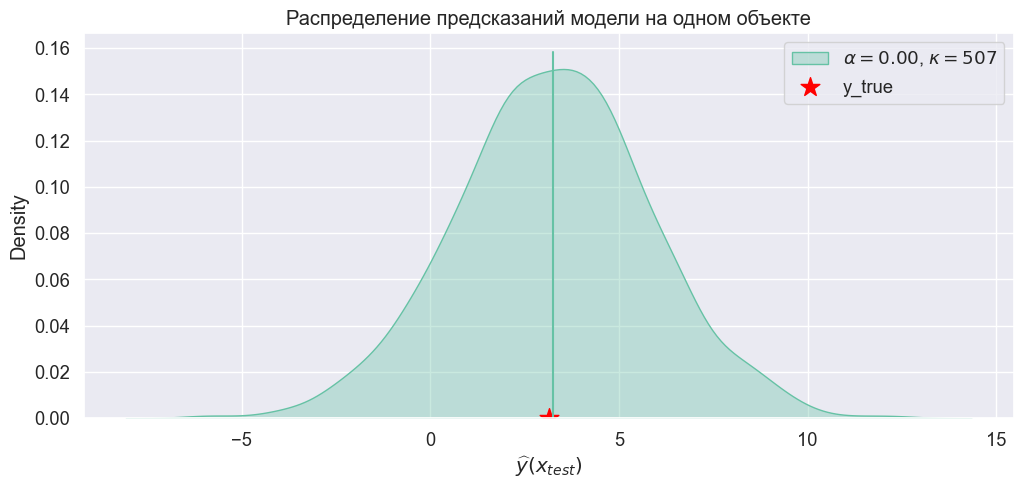

In [31]:
# Рассматриваем линейную регрессию
alpha = 0.0

y_preds, cond = fit_predict_ntimes(X, X_test_point, alpha)

# Записываем результаты эксперимента в общий словарь
predictions = {f"$\\alpha = {alpha:.2f}$, $\\kappa = {cond:.0f}$": y_preds}
visualize_as_kde(
    predictions, y_test, "Распределение предсказаний модели на одном объекте"
)

&#x2753; **Вопрос (в бот)** &#x2753;

> Если данные изначально имеют единый масштаб, как здесь, нужна ли регуляризация? Какие причины могут повлиять на её необходимость?

<details>
  <summary> Кликни для показа ответа </summary>
  
> Стандартизация уменьшает влияние различий в масштабах признаков на оценку коэффициентов, но не устраняет мультиколлинеарность. Однако, если признаки более или менее линейно-**не**зависимы, то регуляризация, действительно, не нужна.

</details><br/>

Распределение ответов модели без регуляризации довольно широкое, т.е. модель неустойчива.

Сделаем $\alpha$ отличным от нуля.

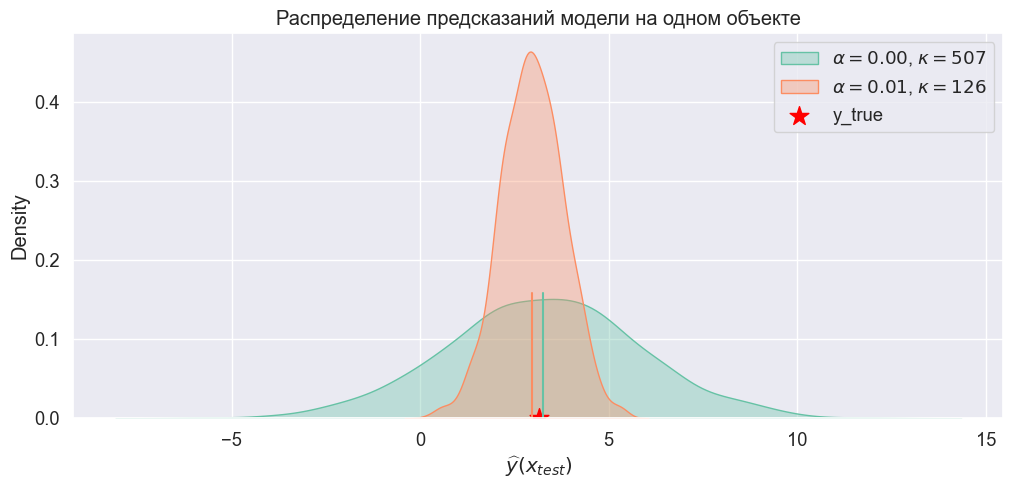

In [32]:
# Рассматриваем линейную регрессию
alpha = 0.01
y_preds, cond = fit_predict_ntimes(X, X_test_point, alpha)

# Записываем результаты эксперимента в общий словарь
predictions[f"$\\alpha = {alpha:.2f}$, $\\kappa = {cond:.0f}$"] = y_preds

visualize_as_kde(
    predictions, y_test, "Распределение предсказаний модели на одном объекте"
)

**Вывод**

Разброс ответов стал меньше. В этом и заключается стабилизирующий эффект регуляризации: ответ модели меньше зависит от небольших флуктуаций в данных, а число обусловленности уменьшилось.

Продолжаем увеличивать штраф:

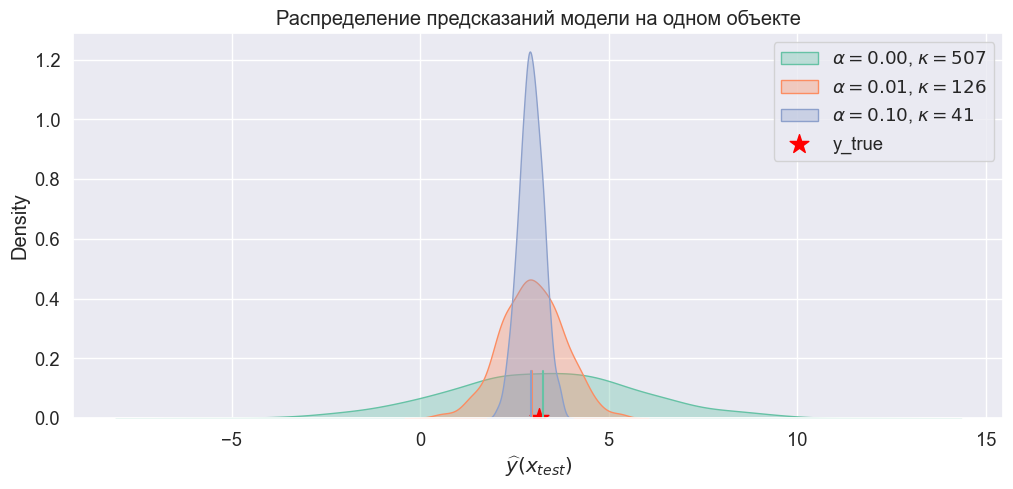

In [33]:
# Рассматриваем линейную регрессию
alpha = 0.1
y_preds, cond = fit_predict_ntimes(X, X_test_point, alpha)

# Записываем результаты эксперимента в общий словарь
predictions[f"$\\alpha = {alpha:.2f}$, $\\kappa = {cond:.0f}$"] = y_preds

visualize_as_kde(
    predictions, y_test, "Распределение предсказаний модели на одном объекте"
)

Дисперсия ответов модели уменьшилась ещё сильнее. Плата за это улучшение &mdash; увеличенное смещение относительно истинного ответа. Таким образом, оптимальный параметр регуляризации является компромиссом между уменьшением разброса предсказаний и смещением их матожидания.

&#x2753; **Вопрос** &#x2753;

> Почему число обусловленности уменьшается при регуляризации? Как это связано с тем, что мы добавили $\alpha I_5$ к матрице $X^TX$?

<details>
  <summary> Кликни для показа ответа </summary>
  
> Собственные числа матрицы $X^TX$ увеличились на константу, поэтому отношение наибольшего и наименьшего собственных чисел снизилось.

</details><br/>

&#x2753; **Вопрос** &#x2753;

> Можно ли применять регуляризацию, если число обусловленности мало? Есть ли риски от сильного подавления коэффициентов регуляризацией?

<details>
  <summary> Кликни для показа ответа </summary>
  
> При маленьком числе обусловенности регуляризация скорее выльется в сильное смещение, нежели повысит устойчивость. Однако, не помешает посмотреть и на другие "маркеры" мультиколлинеарности, чтобы убедиться в её отсутствии. В конце концов, никто не запрещает взять и явно сравнить две модели: с регуляризацией и без.

</details><br/>

&#x2753; **Вопросы на закрепление** &#x2753;

> 1. Что такое мультиколлинеарность, и почему она приводит к нестабильности коэффициентов модели?

<details>
  <summary> Кликни для показа ответа </summary>
  
> Мультиколлинеарность &mdash; это наличие среди признаков зависимостей, близких к линейным. Случайный шум, присутствующий в этих зависимостях, приводит к нестабильности коэффициентов.

</details><br/>

> 2. Как регуляризация помогает бороться с мультиколлинеарностью? (в бот)

<details>
  <summary> Кликни для показа ответа </summary>
  
> Регуляризация задаёт ограничение на норму коэффициентов модели, тем самым распределяя влияние между коррелированными признаками. $L_1$-регуляризация, помимо этого, зануляет часть коэффициентов.

</details><br/>